**前言**：本节内容是 [Datawhale六月组队学习 - 图神经网络- Task7 图预测任务实践](https://github.com/datawhalechina/team-learning-nlp/tree/master/GNN/Markdown%E7%89%88%E6%9C%AC) 的学习笔记，学习周期4天

### 基础准备

In [6]:
import torch
from torch_geometric.data import Data, DataLoader, Batch

### 超大规模数据集类的创建
&emsp;&emsp;在一些应用场景中，数据集规模超级大，我们很难有足够大的内存完全存下所有数据。因此需要一个按需加载样本到内存的数据集类。主要是使用**图样本封装成批（BATCHING）**的方式来实现，好处有:
- 不需要修改GNN算法
- 没有额外计算或内存开|销

#### 图的匹配（Pairs of Graphs）

In [7]:
class PairData(Data):
    def __init__(self, edge_index_s, x_s, edge_index_t, x_t):
        super(PairData, self).__init__()
        self.edge_index_s = edge_index_s
        self.x_s = x_s
        self.edge_index_t = edge_index_t
        self.x_t = x_t

    def __inc__(self, key, value):
        if key == 'edge_index_s':
            return self.x_s.size(0)
        if key == 'edge_index_t':
            return self.x_t.size(0)
        else:
            return super().__inc__(key, value)

In [8]:
edge_index_s = torch.tensor([
    [0, 0, 0, 0],
    [1, 2, 3, 4],
])
x_s = torch.randn(5, 16)  # 5 nodes.
edge_index_t = torch.tensor([
    [0, 0, 0],
    [1, 2, 3],
])
x_t = torch.randn(4, 16)  # 4 nodes.
data = PairData(edge_index_s, x_s, edge_index_t, x_t)
data_list = [data, data]

loader = DataLoader(data_list, batch_size=2, follow_batch=['x_s', 'x_t'])
batch = next(iter(loader))

print(batch)
print(batch.x_s_batch)
print(batch.x_t_batch)

Batch(edge_index_s=[2, 8], edge_index_t=[2, 6], x_s=[10, 16], x_s_batch=[10], x_t=[8, 16], x_t_batch=[8])
tensor([0, 0, 0, 0, 0, 1, 1, 1, 1, 1])
tensor([0, 0, 0, 0, 1, 1, 1, 1])


#### 二部图（Bipartite Graphs）

In [9]:
class BipartiteData(Data):
    def __init__(self, edge_index, x_s, x_t):
        super(BipartiteData, self).__init__()
        self.edge_index = edge_index
        self.x_s = x_s
        self.x_t = x_t
   
    def __inc__(self, key, value):
        if key == 'edge_index':
            return torch.tensor([[self.x_s.size(0)], [self.x_t.size(0)]])
        else:
            return super().__inc__(key, value)

In [10]:
edge_index = torch.tensor([
    [0, 0, 1, 1],
    [0, 1, 1, 2],
])
x_s = torch.randn(2, 16)  # 2 nodes.
x_t = torch.randn(3, 16)  # 3 nodes.

data = BipartiteData(edge_index, x_s, x_t)
data_list = [data, data]
loader = DataLoader(data_list, batch_size=2)
batch = next(iter(loader))

print(batch)
print(batch.edge_index)

Batch(batch=[6], edge_index=[2, 8], ptr=[3], x_s=[4, 16], x_t=[6, 16])
tensor([[0, 0, 1, 1, 2, 2, 3, 3],
        [0, 1, 1, 2, 3, 4, 4, 5]])


#### 在新的维度上做拼接

In [11]:
 class MyData(Data):
     def __cat_dim__(self, key, item):
         if key == 'foo':
             return None
         else:
             return super().__cat_dim__(key, item)

In [12]:
edge_index = torch.tensor([
   [0, 1, 1, 2],
   [1, 0, 2, 1],
])
foo = torch.randn(16)

data = MyData(edge_index=edge_index, foo=foo)
data_list = [data, data]
loader = DataLoader(data_list, batch_size=2)
batch = next(iter(loader))

print(batch)
# Batch(edge_index=[2, 8], foo=[2, 16])

Batch(batch=[6], edge_index=[2, 8], foo=[2, 16], ptr=[3])


### 作业
- 请小伙伴们进行不同超参数的试验，通过观察不同试验的过程与结果信息的差别分析不同超参数对图预测任务的影响。

由于运行比较耗时，在我的机器上运行预计需要59*10min，因此我对超参数做了一定的调整来节省时间：
- batch_size 512 -> 128
- epochs 100 -> 20
- num_workers 4 -> 8  

经调整后预计需要20*20min。

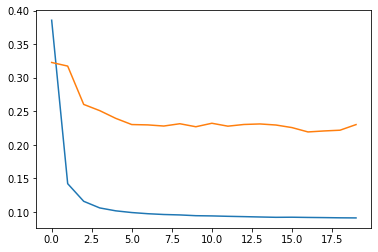

In [62]:
import re
import matplotlib.pyplot as plt
f = open('./作业和笔记/gin_regression/saves/GINGraphPooling =0/output')
output = ''.join([line.strip() for line in f.readlines()])
output = re.findall('Epoch.*', output)[0]
output = [re.findall('{.*}', tmp)[0] for tmp in output.split('=====')]
result = [eval(tmp) for tmp in output]

train_log = [tmp['Train'] for tmp in result ]
val_log = [tmp['Validation'] for tmp in result]

plt.plot(train_log)
plt.plot(val_log)
plt.show()

通过保存的输出文件可以发现，模型在训练集上的MAE稳定在0.1左右，在验证集上的MAE稳定在0.25左右。